# Tutorial2: Analyzing GAN Geometry and Explore the Axes
This basically correspond to Figure 2 and 3.

First let's sample more points and collects more metric tensors.

In [1]:
import os
from os.path import join
from tqdm import tqdm
from time import time
import numpy as np
import torch
import matplotlib.pylab as plt
from core import get_full_hessian, hessian_compute, save_imgrid, show_imgrid, plot_spectra, hessian_summary_pipeline
from core.GAN_utils import DCGAN_wrapper, loadDCGAN, BigGAN_wrapper, loadBigGAN, upconvGAN
import lpips
ImDist = lpips.LPIPS(net="squeeze", )

Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]
Loading model from: C:\Users\binxu\.conda\envs\tf\lib\site-packages\lpips\weights\v0.1\squeeze.pth


Let's take the simplest model DCGAN (trained on fashion dataset) and analyze its geometry!

In [2]:
DG = loadDCGAN()
DG.cuda().eval()
DG.requires_grad_(False)
G = DCGAN_wrapper(DG)

Using cache found in C:\Users\binxu/.cache\torch\hub\facebookresearch_pytorch_GAN_zoo_hub


Average network found !


Get some coffee and run Hessian computation at multiple points in the latent space! (Using BackProp method, it takes around 270 secs for 30 different points.)

In [4]:
trials = 30
savedir = join("hessian\\DCGAN")
os.makedirs(savedir, exist_ok=True)

In [ ]:
T0 = time()
for triali in tqdm(range(trials)):
    feat = G.sample_vector(sampn=1)  #.detach().clone().cuda()
    eva_BP, evc_BP, H_BP = hessian_compute(G, feat, ImDist, hessian_method="BP")
    #eva_FI, evc_FI, H_FI = hessian_compute(G, feat, ImDist, hessian_method="ForwardIter", EPS=1E-4)
    np.savez(join(savedir, "Hess_BP_%d.npz" % triali), eva_BP=eva_BP, evc_BP=evc_BP, H_BP=H_BP, feat=feat.cpu().detach().numpy())
print("Total time %.2f sec"%(time() - T0))

Now plot summary statistics on the hessians you computed:

* Distribution of spectra at different points
* Hessian consistency across points
* Examples of Hessian correlation at 3 points or 5 points

30it [00:00, 577.26it/s]
100%|██████████| 30/30 [00:00<00:00, 75.61it/s]


Load 30 npz files of Hessian info
1.1 sec
Compute results saved to hessian\DCGAN\summary\Hess_DCGAN_corr_mat.npz
Log scale non-diag mean corr value 0.952 med 0.954
Lin scale non-diag mean corr value 0.739 med 0.777
0.4 sec
Compute results saved to hessian\DCGAN\summary\Hess_DCGAN_corr_mat_vec.npz
Log scale non-diag mean corr value 0.952
Lin scale non-diag mean corr value 0.739


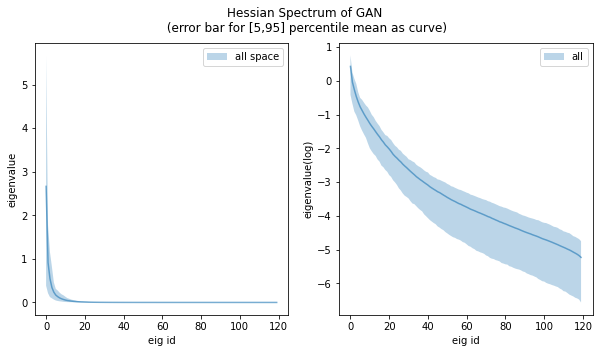

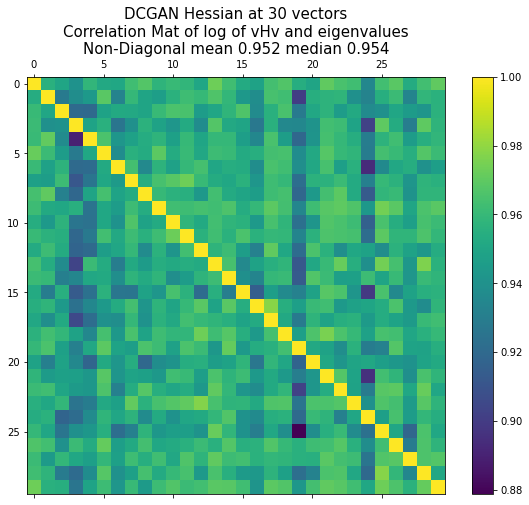

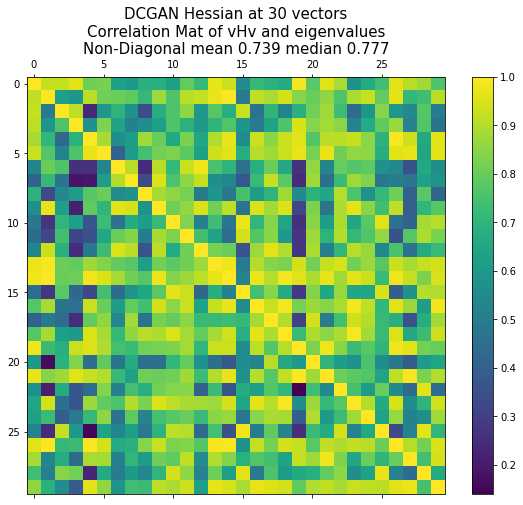

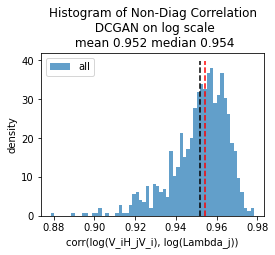

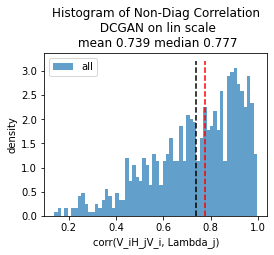

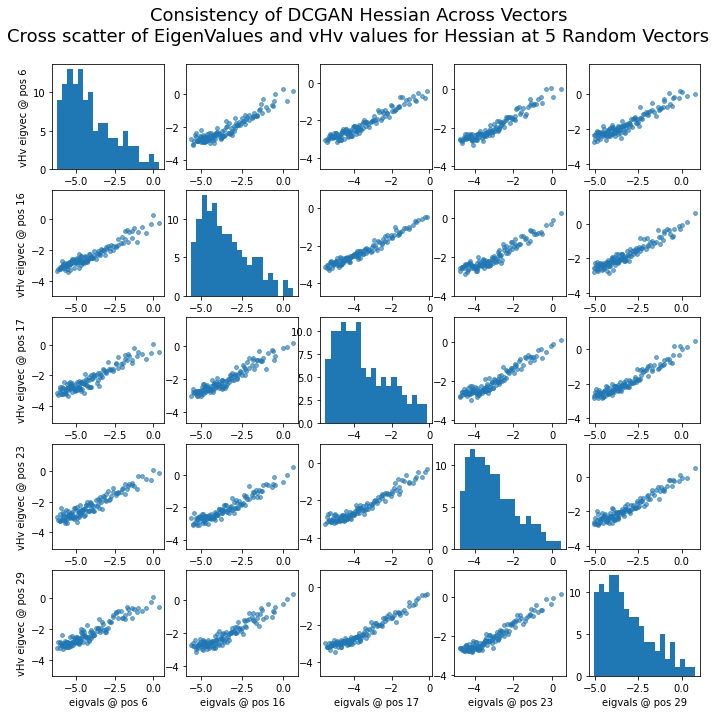

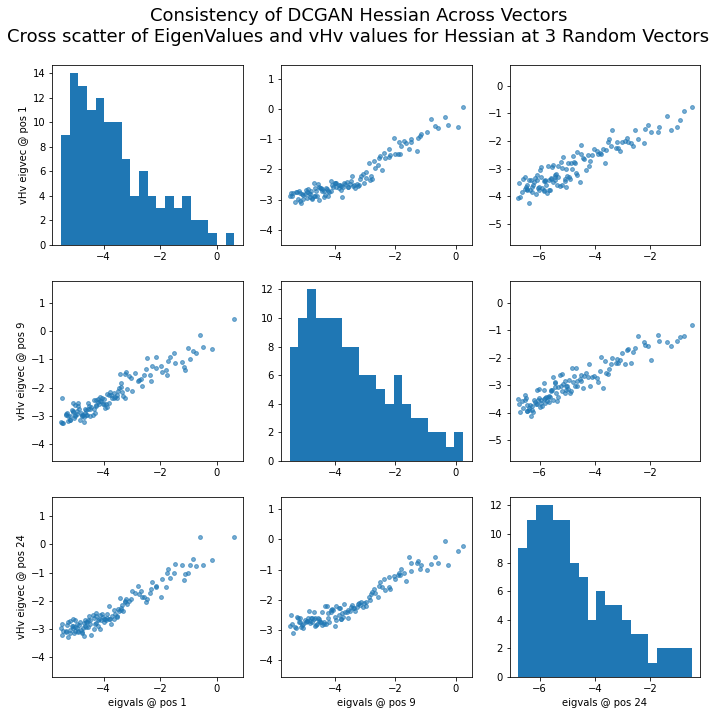

In [5]:
sumdir = join("hessian\\DCGAN\\summary")
os.makedirs(sumdir, exist_ok=True)
S = hessian_summary_pipeline(savedir, "DCGAN", sumdir, npzpatt="Hess_BP_(\d*).npz", featkey="feat", evakey='eva_BP', evckey='evc_BP', )

Are the correlation or consistency of Hessian matrices are related to the distance structure of the reference vectors? Seems not!

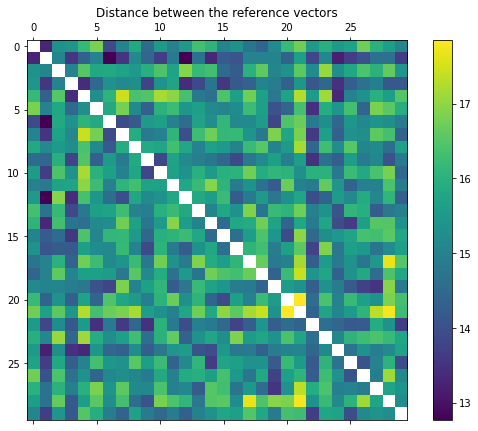

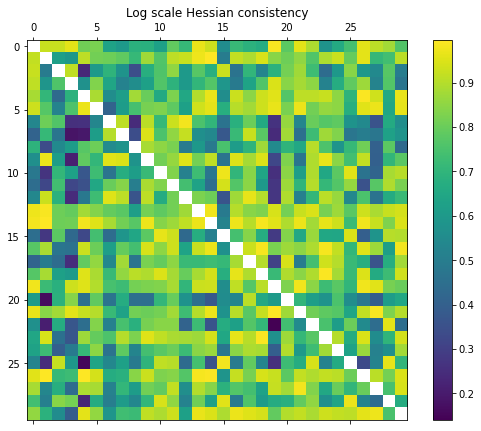

In [51]:
from scipy.spatial.distance import pdist, squareform
import numpy.ma as ma
distmat_feat = squareform(pdist(S.feat_col, metric="euclidean")) # cosine
distmat_feat += np.diag(np.nan * np.ones((distmat_feat.shape[0])))
plt.figure(figsize=[9,7])
plt.matshow(distmat_feat,fignum=0)
plt.title("Distance between the reference vectors")
plt.colorbar()
plt.show()
plt.figure(figsize=[9,7])
plt.matshow(S.corr_mat_lin,fignum=0)
plt.title("Log scale Hessian consistency")
plt.colorbar()
plt.show()

In [50]:
from scipy.stats import pearsonr
# cc = ma.corrcoef(ma.masked_invalid(S.corr_mat_lin.flatten()), ma.masked_invalid(distmat_feat.flatten()))[0,1]
msk = np.isnan(distmat_feat.flatten())
cval, pval = pearsonr(S.corr_mat_log.flatten()[~msk], distmat_feat.flatten()[~msk])
print("Pearson Corr of the distance between the feature tensor and the log Hessian consistency %.3f (P=%.1e)"%(cval, pval))
cval, pval = pearsonr(S.corr_mat_lin.flatten()[~msk], distmat_feat.flatten()[~msk])
print("Pearson Corr of the distance between the feature tensor and the lin Hessian consistency %.3f (P=%.1e)"%(cval, pval))

Pearson Corr of the distance between the feature tensor and the log Hessian consistency 0.088 (P=9.4e-03)
Pearson Corr of the distance between the feature tensor and the lin Hessian consistency 0.032 (P=3.4e-01)


## Mechanism behind the Geometry
How does this geometric structure comes into being? Recall the connection between the Jacobian of generator and the metric tensor.

$$H=J^TJ$$

We can look into the architecture of the DCGAN model. First let's look into the inner modules of DCGAN.

In [5]:
G.DCGAN.module

GNet(
  (formatLayer): ConvTranspose2d(120, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (main): Sequential(
    (batchNorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (convTranspose1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (convTranspose2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (convTranspose3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (outlayer): ConvTranspo

In [6]:
L2dist_col = {}
def L2dist_hook(module, fea_in, fea_out):
    print("hooker on %s"%module.__class__)
    ref_feat = fea_out.detach().clone()
    ref_feat.requires_grad_(False)
    L2dist = torch.pow(fea_out - ref_feat, 2).sum()
    L2dist_col["dist"] = L2dist
    return None

In [7]:
feat = torch.randn(1, 120).cuda()
feat.requires_grad_(True);

tensor([[ 0.2246, -0.8666, -0.6490,  0.9632, -0.9716,  3.7552,  0.9942, -1.0240,
         -0.6419, -2.1258,  0.6844, -0.3674, -0.8240,  1.0511, -0.5526,  0.3764,
         -0.2359, -0.2776,  0.2485,  1.4973,  0.7103, -0.6197, -0.1637, -1.4665,
          2.0408,  1.2118, -0.3779, -0.2404,  2.2758,  0.0301, -0.7030, -0.2673,
         -3.6283,  0.2479, -1.5334,  0.0327, -0.7612, -0.8514, -0.7762,  1.0498,
         -0.1269,  0.6037, -0.5010,  1.6296,  0.4284,  0.7067,  1.5428, -0.6239,
         -1.0099,  0.3764,  1.2402,  0.0359,  0.4704,  0.4276,  0.6986,  0.2529,
         -1.3000, -0.2053,  1.7192,  1.8211, -0.3146,  0.0868, -0.8297, -0.7214,
          2.6729,  1.5727,  2.4669,  0.0403,  1.9152,  0.2600,  1.4784, -0.5468,
         -1.0514, -1.8923,  0.6480,  0.8232,  0.4002,  0.6511, -1.4341, -0.4494,
          2.2568, -2.3905, -0.8850,  0.8071,  1.1447, -0.1959,  0.9190, -0.0479,
         -0.3040, -0.0165,  1.2563,  0.5122, -0.0804,  2.2044, -0.5981, -0.0860,
         -0.7148,  0.1673, -

 [================================================================>]  Step: 8ms | Tot: 1s25ms | full hessian columns: 119 of 120 120/120 
Spent 1.25 sec computing


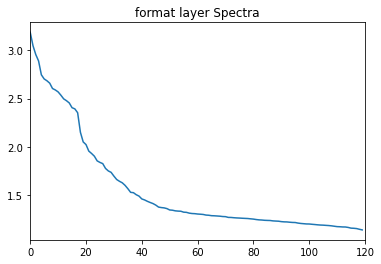

In [9]:
"""Compute Hessian towards middle layers layer by layer"""
datadir = r"hessian\\DCGAN_layers"
figdir = r"hessian\\DCGAN_layers\\summary"
os.makedirs(figdir, exist_ok=True)
torch.cuda.empty_cache()
H1 = G.DCGAN.module.formatLayer.register_forward_hook(L2dist_hook)
img = G.visualize(feat)
H1.remove()
T0 = time()
H00 = get_full_hessian(L2dist_col["dist"], feat)
eva00, evc00 = np.linalg.eigh(H00)
print("Spent %.2f sec computing" % (time() - T0))
np.savez(join(datadir, "eig_format_layer.npz"), H=H00, eva=eva00, evc=evc00)
plt.plot(np.log10(eva00)[::-1])
plt.title("format layer Spectra" % ())
plt.xlim([0, len(evc00)])
plt.savefig(join(figdir, "spectrum_format.png" ))
plt.show()

 [================================================================>]  Step: 17ms | Tot: 1s953ms | full hessian columns: 119 of 120 120/120 
Spent 1.98 sec computing


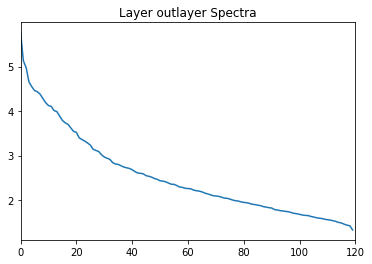

In [15]:
L2dist_col = {}
for name, layer in G.DCGAN.module.main.named_children():
    torch.cuda.empty_cache()
    H1 = layer.register_forward_hook(L2dist_hook)
    img = G.visualize(feat)
    H1.remove()
    T0 = time()
    H00 = get_full_hessian(L2dist_col["dist"], feat)
    eva00, evc00 = np.linalg.eigh(H00)
    print("Spent %.2f sec computing" % (time() - T0))
    np.savez(join(datadir, "eig_%s.npz"%name), H=H00, eva=eva00, evc=evc00)
    plt.plot(np.log10(eva00)[::-1])
    plt.title("Layer %s Spectra" % (name,))
    plt.xlim([0, len(evc00)])
    plt.savefig(join(figdir, "spectrum_%s.png" % (name)))
    plt.show()

Now let's analyze the Jacobian and their eigen structure against each other

In [24]:
from core.hessian_analysis_tools import plot_layer_consistency_mat, plot_layer_consistency_example, plot_layer_amplif_curves, plot_layer_amplif_consistency, compute_plot_layer_corr_mat

In [21]:
layernames = ["format_layer"] + \
             list(name for name, _ in G.DCGAN.module.main.named_children())
eva_col, evc_col, H_col = [], [], []
for name in layernames:
    data = np.load(join(datadir, "eig_%s.npz" % name))
    eva_col.append(data["eva"])
    evc_col.append(data["evc"])
    H_col.append(data["H"])

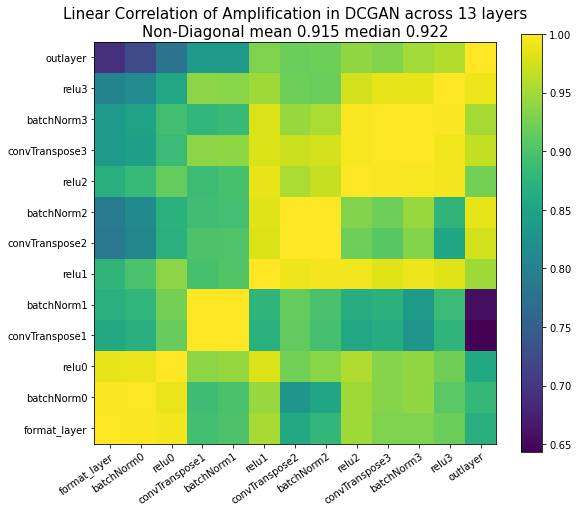

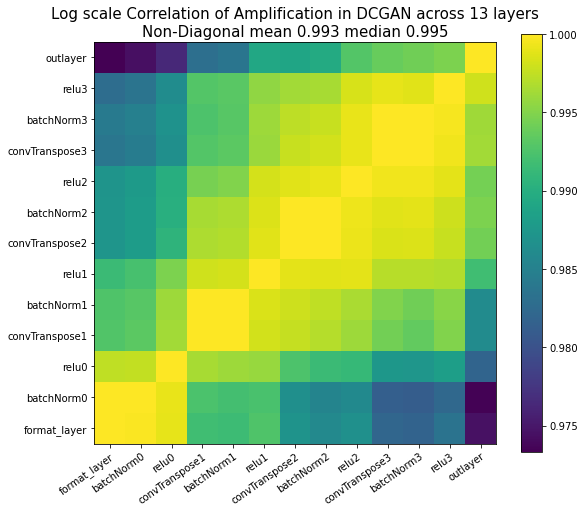

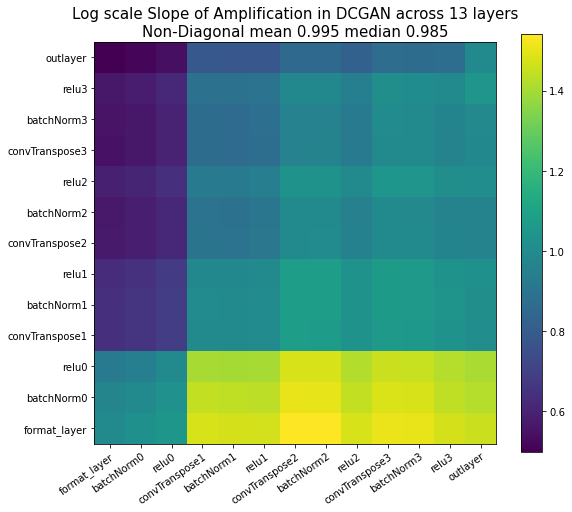

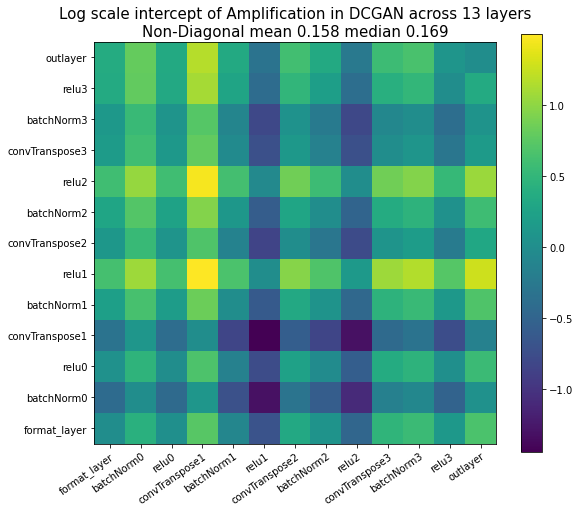

In [27]:
compute_plot_layer_corr_mat(eva_col, evc_col, H_col, layernames, titstr="DCGAN", savestr="DCGAN", figdir=figdir);

Plot hessian of layers :  ['format_layer', 'batchNorm0', 'relu0', 'outlayer']


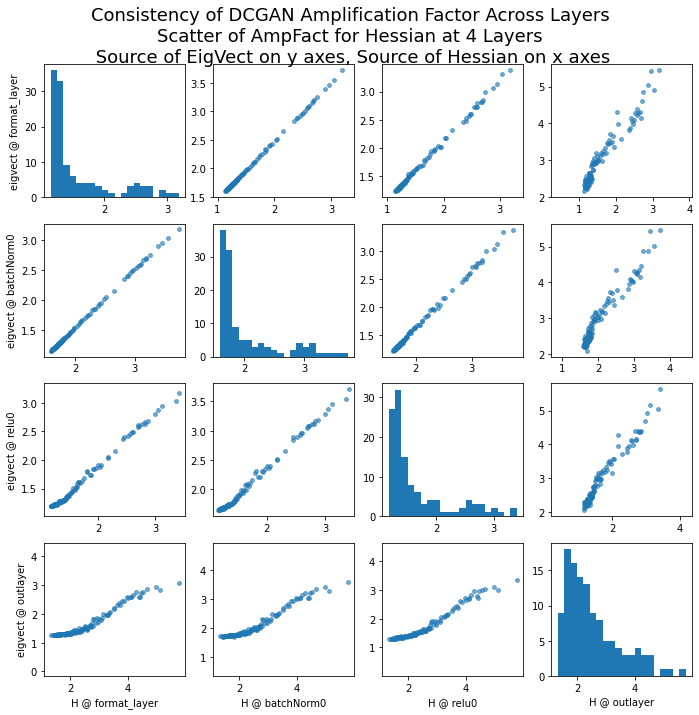

In [28]:
plot_layer_amplif_consistency(eva_col, evc_col, layernames, layeridx=[0,1,2,-1], titstr="DCGAN", savelabel="DCGAN", figdir=figdir);